<p align="center">بسم الله الرحمن الرحیم</p>

# Library

In [1]:
! pip install transformers
! pip install git+https://github.com/openai/CLIP.git
! pip install vit_pytorch>=0.25.6
! pip install x-clip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-5084t99z
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-5084t99z
  Resolved https://github.com/openai/CLIP.git to commit 3702849800aa56e2223035bccd1c6ef91c704ca8
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import time
import copy
import PIL
import torch
import os
from io import BytesIO
import clip
import requests
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from transformers import AutoTokenizer, BertModel
from x_clip import CLIP, TextTransformer
from vit_pytorch import ViT
from vit_pytorch.extractor import Extractor
import matplotlib.pyplot as plt


print("Torch version:", torch.__version__)

Torch version: 1.13.1+cu116


# Config and Hyper-parameter

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
TEST_SIZE = 0.1
VAL_SIZE = 0.1
BATCH_SIZE = 256
EPOCH = 10
LR = 1e-7
EPS = 1e-9
WEIGHT_DECAY = 0.1
MAX_LR = 1e-2
BASE_MODEL_PATH = '/content/drive/MyDrive/clip_trained_model/'

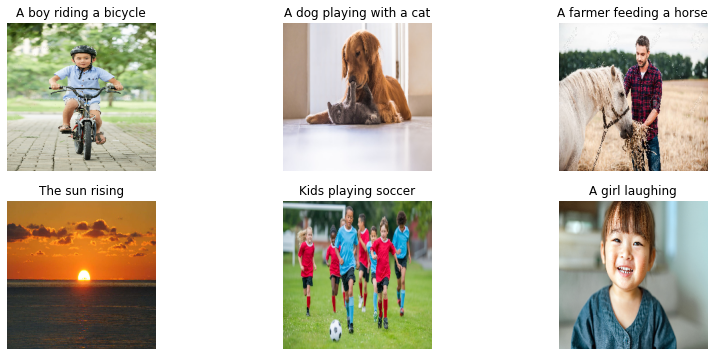

In [34]:
image_urls = ["https://s3.envato.com/files/273742079/DSC_1768.jpg",
              "https://www.omlet.us/images/originals/british_shorthair_playing_with_dog.jpg",
              "https://previews.123rf.com/images/gstockstudio/gstockstudio1509/gstockstudio150900214/45292178-i-love-this-horse-side-view-of-young-farmer-feeding-horse-while-standing-in-the-field.jpg",
              "https://static.toiimg.com/photo/45773211.cms",
              "https://www.rand.org/content/rand/blog/2020/07/california-could-develop-guidance-to-reopen-youth/_jcr_content/par/blogpost.aspectcrop.868x455.ct.jpg/1595445851928.jpg",
              "https://media-cldnry.s-nbcnews.com/image/upload/rockcms/2022-10/girl-names-that-start-with-c-zz-221027-768b76.jpg"]

texts = ['A boy riding a bicycle', 
         'A dog playing with a cat', 
         'A farmer feeding a horse', 
         'The sun rising', 
         'Kids playing soccer',
         "A girl laughing"]


images = []
for url in image_urls:
    response = requests.get(url)
    tmp = PIL.Image.open(BytesIO(response.content)).convert("RGB")
    tmp = tmp.resize((224, 224), resample=0)
    images.append(np.array(tmp))
images = np.array(images).astype('float32')

plt.figure(figsize=(14, 6))
for i in range(6):
    plt.subplot(23*10+i+1)
    plt.imshow(images[i].astype('int'))
    plt.title(texts[i])
    plt.axis('off')
plt.show()

In [5]:
bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [41]:
base_vit = ViT(
    image_size = 224,
    patch_size = 32,
    num_classes = 1000,
    dim = 768,
    depth = 6,
    heads = 16,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
)

image_encoder = Extractor(
    base_vit,
    return_embeddings_only = True
)

text_encoder = TextTransformer(
    dim = 768,
    dim_head = 256,
    num_tokens = 50000,
    max_seq_len = 256,
    depth = 6,
    heads = 8
)

model = CLIP(
    image_encoder = image_encoder,
    text_encoder = text_encoder,
    dim_image = 768,
    dim_text = 768,
    dim_latent = 768
)

In [7]:
text_test = torch.randint(0, 10000, (6, 256))
images_test = torch.randn(6, 3, 224, 224)
print(text_test.shape, images_test.shape)
loss = model(text_test, images_test, return_loss = True)
loss

torch.Size([6, 256]) torch.Size([6, 3, 224, 224])


tensor(1.7778, grad_fn=<AddBackward0>)

In [8]:
ntexts = clip.tokenize(texts, context_length=256)
images_tensor = torch.from_numpy(images)
images_tensor = torch.permute(images_tensor, (0,3,2,1))
print(ntexts.shape, images_tensor.shape)

torch.Size([6, 256]) torch.Size([6, 3, 224, 224])


In [9]:
np.max(ntexts[0].numpy())

49407

In [10]:
loss = model(ntexts, images_tensor, return_loss = True)
loss

tensor(1.7904, grad_fn=<AddBackward0>)

In [11]:
text = "Breast, left, simple mastectomy: Invasive ductal carcinoma, \
  Nottingham grade III (of III), is identified forming a 6.0 x 4.0 x 3.5cm tumor\
   (AJCC pT3 ) in the central-upper inner region of the breast . \
   The deep and lateral margins of resection are negative for tumor. The closest\
    margin is deep and is free by 1 .0 cm. The overlying skin and nipple are not \
    involved by carcinoma. Breast, right, simple mastectomy : Invasive ductal carcinoma, \
    Nottingham grade III (of III), is identified forming a 1 .7 x 1.3 x 1.0 cm tumor (AJCC pT1 c) \
    in the upper outer region of the breast. The deep and lateral margins of \
    resection are negative for tumor. The closest margin is deep and is free by 2 .8 cm. \
    The overlying skin and nipple are negative for involvement by carcinoma."
t = bert_tokenizer(text, return_tensors="pt")

In [12]:
texts.append(text)

In [48]:
a = bert_tokenizer(texts, max_length=256, padding=True, truncation=True)

In [51]:
a['input_ids']

[[101, 1037, 2879, 5559, 1037, 10165, 102, 0],
 [101, 1037, 3899, 2652, 2007, 1037, 4937, 102],
 [101, 1037, 7500, 8521, 1037, 3586, 102, 0],
 [101, 1996, 3103, 4803, 102, 0, 0, 0],
 [101, 4268, 2652, 4715, 102, 0, 0, 0],
 [101, 1037, 2611, 5870, 102, 0, 0, 0]]

In [14]:
out = bert_model(**a)

In [19]:
out['pooler_output'].shape

torch.Size([7, 768])

In [18]:
out.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

In [20]:
model2 = CLIP(
    image_encoder = image_encoder,
    text_encoder = bert_model,
    dim_image = 768,
    dim_text = 768,
    dim_latent = 768
)

In [40]:
?model2

In [44]:
loss = model2(a['input_ids'], images_tensor, return_loss = True)
loss

AttributeError: ignored

In [47]:
a['input_ids'].dtype
ntexts.dtype

torch.int32